Python CVXPY を使ったハンズオン演習

In [9]:
! pip install cvxpy
! pip install ecos



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\tanak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\tanak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# --- データの準備 ---
t = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([0.002286, 0.1261, 0.2440, 0.3950, 0.5516, 0.7502,
              0.9696, 1.189, 1.465, 1.718, 0.03243])

n = 101  # 多項式次数 + 1（x^0 ～ x^100）
Phi_e = np.vander(t, N=n)

# --- スパース推定（L1ノルム最小化） ---
x = cp.Variable(n, integer=True)  # 整数型に設定

# 目的関数: L1ノルム最小化
cost = cp.norm1(x)

# 制約条件
constraints = [
    Phi_e @ x == y,  # 予測値と観測値が一致すること
    cp.norm1(x) == 4,  # 非ゼロの係数が4つであること
    x[100] != 0,  # x^100の係数は非ゼロであること
    x >= -1,  # 係数は-1またはそれより大きい
    x <= 1,  # 係数は1またはそれより小さい
    # 他の整数制約: xは-1, 0, 1である必要がある
    x == cp.multiply(x, cp.abs(x) <= 1),  # xの値を-1、0、1に制限
]

# 最適化問題の設定と解決
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver=cp.ECOS_BB)

# --- 結果出力 ---
print("status:", prob.status)
print("optimal value:", prob.value)

# --- 推定された多項式の描画 ---
mm = 101
dd = 1/(mm-1)
time = np.arange(0, 1 + dd, dd)

if x.value is not None:
    fig, ax = plt.subplots()
    ax.plot(time, np.polyval(x.value, time), label='Sparse poly (L1 norm)')
    ax.plot(t, y, 'o', label='Sample points')
    ax.legend()
    ax.grid()
    ax.set_title("Sparse Polynomial Fitting")
    
    if x.value is not None:
        nonzero_indices = np.flatnonzero(np.abs(x.value) > 1e-6)  # 小さな値を無視
        
        nonzero_values = x.value[nonzero_indices]

    print("非ゼロ要素の数:", len(nonzero_indices))
    print("非ゼロの係数インデックス:", nonzero_indices)
    print("非ゼロの係数の値:", nonzero_values)

    # --- 推定された係数の表示 ---
    plt.figure()
    plt.stem(x.value)
    plt.ylim(-1.1, 1.1)
    plt.title("Estimated Sparse Coefficients")
    plt.grid()
    plt.show()
else:
    print("最適化が失敗しました。x.value is None")


Exception: Cannot evaluate the truth value of a constraint or chain constraints, e.g., 1 >= x >= 0.

status: optimal
optimal value: 23.130274737691586
非ゼロ要素の数: 9
非ゼロの係数インデックス: [ 58  59  60  61  62  97  98  99 100]
非ゼロの係数の値: [-1.22585171e-06 -4.10529443e-03 -1.09997269e+00 -9.29570196e-01
 -1.78323464e-06  1.94601672e-01  8.62841994e-01  1.00000000e+00
  8.89893416e-03]


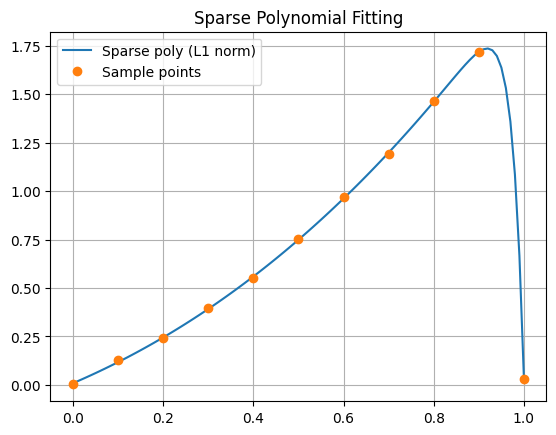

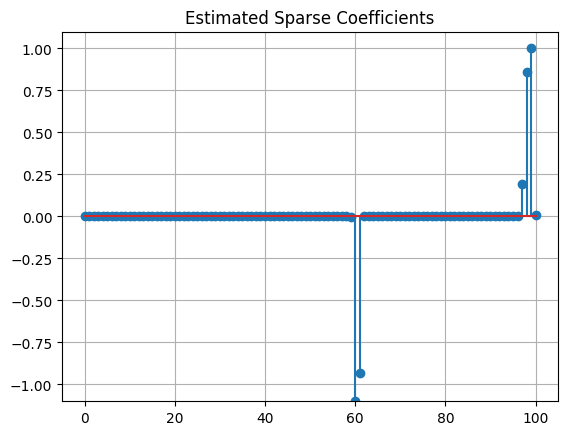

In [4]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# --- データの準備 ---
t = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([0.002286, 0.1261, 0.2440, 0.3950, 0.5516, 0.7502,
              0.9696, 1.189, 1.465, 1.718, 0.03243])

n = 101  # 多項式次数 + 1（x^0 ～ x^100）
Phi_e = np.vander(t, n)

# --- スパース推定（L1ノルム最小化） ---
x = cp.Variable(n)
#cost = cp.norm1(x)
cost = cp.norm1(x) + 1e3 * cp.norm2(Phi_e @ x - y)
constraints = [
    #Phi_e @ x == y,
    x <= 1.1,
    x >= -1.1,
    
    cp.norm1(x) <= 4.1,
    x[n-2] == 1  # x^100の係数は非ゼロ
]
prob = cp.Problem(cp.Minimize(cost), constraints)
#prob.solve(solver=cp.ECOS_BB)
prob.solve()
# --- 結果出力 ---
print("status:", prob.status)
print("optimal value:", prob.value)

# --- 推定された多項式の描画 ---
mm = 101
dd = 1/(mm-1)
time = np.arange(0, 1 + dd, dd)

if x.value is not None:
    
    fig, ax = plt.subplots()
    ax.plot(time, np.polyval(x.value, time), label='Sparse poly (L1 norm)')
    ax.plot(t, y, 'o', label='Sample points')
    ax.legend()
    ax.grid()
    ax.set_title("Sparse Polynomial Fitting")
    if x.value is not None:
        nonzero_indices = np.flatnonzero(np.abs(x.value) > 1e-6)  # 小さな値を無視
        
        nonzero_values = x.value[nonzero_indices]

    print("非ゼロ要素の数:", len(nonzero_indices))
    print("非ゼロの係数インデックス:", nonzero_indices)
    print("非ゼロの係数の値:", nonzero_values)

    # --- 推定された係数の表示 ---
    plt.figure()
    plt.stem(x.value)
    plt.ylim(-1.1, 1.1)
    plt.title("Estimated Sparse Coefficients")
    plt.grid()
    plt.show()
else:
    print("最適化が失敗しました。x.value is None")




選ばれたインデックス: [100   0  98  99]
選ばれた係数の値: [-1.         -0.60948261  0.58747797  1.9       ]


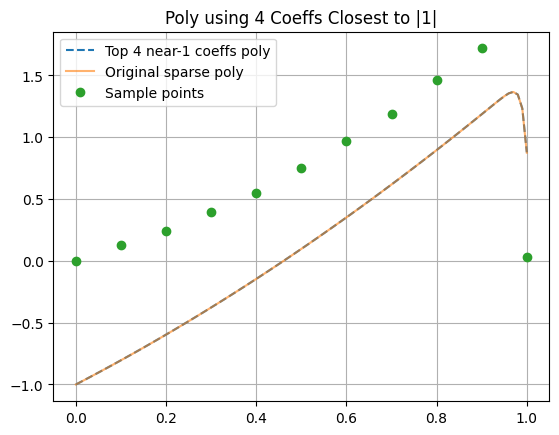

選ばれたインデックス: [100   0  98  99]
選ばれた係数の値: [-1.         -0.60948261  0.58747797  1.9       ]


In [2]:
if x.value is not None:
    # --- 絶対値が1に近い4つの係数を選択 ---
    abs_diff = np.abs(np.abs(x.value) - 1)  # |係数|と1の差
    top4_indices = np.argsort(abs_diff)[:4]  # 差が小さい順に4つ

    # 新しい係数ベクトル（他はゼロ）
    sparse_x = np.zeros_like(x.value)
    sparse_x[top4_indices] = x.value[top4_indices]

    print("選ばれたインデックス:", top4_indices)
    print("選ばれた係数の値:", x.value[top4_indices])   
    # --- 再構築された多項式の描画 ---
    fig, ax = plt.subplots()
    ax.plot(time, np.polyval(sparse_x, time), label='Top 4 near-1 coeffs poly', linestyle='--')
    ax.plot(time, np.polyval(x.value, time), label='Original sparse poly', alpha=0.6)
    ax.plot(t, y, 'o', label='Sample points')
    ax.legend()
    ax.grid()
    ax.set_title("Poly using 4 Coeffs Closest to |1|")
    plt.show()

    print("選ばれたインデックス:", top4_indices)
    print("選ばれた係数の値:", x.value[top4_indices])


In [ ]:
import cvxpy as cp
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline


# 与えられた t, y データ
t = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([0.002286, 0.1261, 0.2440, 0.3950, 0.5516, 0.7502,
              0.9696, 1.189, 1.465, 1.718, 0.03243])  # 11 個あるので t も11個必要

# t に合わせて Vandermonde 行列を生成（次数100）
n = 101  # x^0 〜 x^100
m=11  # t の数

In [ ]:
# Vandermonde matrix
Phi = np.vander(t)
# Solve linear equation Phi * x = y
x_11 = LA.solve(Phi,y)
# Plot the obtained curve
mm = 101
dd = 1/(mm-1)
time = np.arange(0,1+dd,dd)
# Extended Vandermonde matrix
Phi_e = np.vander(t,n)
# optimization variable
x = cp.Variable(n)
# cost function (L1 norm)
cost = cp.norm1(x)
# constraints (linear equations)
#constraints = [Phi_e @ x == y]
constraints = [
    Phi_e @ x == y,  # 線形方程式
    x <= 1,
    x >= -1,
    cp.norm1(x) == 4,     # 非ゼロ係数が4個だけ（±1の合計絶対値が4）
    x[n-1] >= 1e-3   

]
# optimization problem
prob = cp.Problem(cp.Minimize(cost), constraints)
# solve by CVXPY
prob.solve()
# print the result
print("status:", prob.status)
print("optimal value", prob.value)

# Plot the obtained curve
fig, ax = plt.subplots()
ax.plot(time, np.polyval(x.value,time), label='80th poly (Sparse)')
ax.plot(time, np.polyval(x_orig,time), label='original')
ax.legend()
ax.grid()

# Plot the obtained coefficients
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig)
plt.ylim(-1.1,1.1)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(x.value)
plt.ylim(-1.1,1.1)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
norm1(var176) == 4.0 , because the following subexpressions are not:
|--  norm1(var176) == 4.0

In [26]:
import cvxpy as cp
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline

# 与えられた t, y データ
t = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([0.002286, 0.1261, 0.2440, 0.3950, 0.5516, 0.7502,
              0.9696, 1.189, 1.465, 1.718, 0.03243])  # t と要素数を一致

# t に合わせて Vandermonde 行列を生成（次数100）
n = 101  # x^0 〜 x^100
Phi = np.vander(t, n, increasing=True)

# 最適化変数
x = cp.Variable(n)

# コスト関数（L1ノルム）
cost = cp.norm1(x)

# 制約条件
constraints = [
    x <= 1,
    x >= -1,
    cp.norm1(x) == 4,     # 非ゼロ係数が4個だけ（±1の合計絶対値が4）
    x[n-1] >= 1e-3        # x^100 の係数は非ゼロ
]

# 最適化問題
prob = cp.Problem(cp.Minimize(cost), constraints)

# 解を求める
prob.solve()

# 結果を表示
print("status:", prob.status)
print("optimal value:", prob.value)

# プロット
time = np.linspace(0, 1, 101)
fig, ax = plt.subplots()
ax.plot(time, np.polyval(np.flip(x.value), time), label='80th poly (Sparse)')
ax.plot(time, np.polyval(np.flip(x_orig), time), label='original')
ax.legend()
ax.grid()

# 係数のプロット
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.stem(np.flip(x_orig))
ax1.set_ylim(-1.1, 1.1)
ax2.stem(np.flip(x.value))
ax2.set_ylim(-1.1, 1.1)
plt.show()

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
norm1(var198) == 4.0 , because the following subexpressions are not:
|--  norm1(var198) == 4.0